<h1>Finenzyme generation and fine-tuning tutorial</h1>

**Welcome to Finenzyme tutorial!**

In this notebook you will learn how to:
1. **Use the pre-trained Finenzyme**: By using the Pre-trained Finenzyme, it is possible to generate new artificial proteins. The generation can be guided by a set of specific tags, and a starting "slice" or prefix of a protein.
2. **Fine-tuning Finenzyme**: You can specialize Finenzyme for your favourite set of UniProt proteins!
3. **Use the fine-tuned Finenzyme**: Once Finenzyme is specialized for a specific protein set, you can generate new proteins from your favourite set of proteins! Or even evolve already existing proteins.

*Imagine.. a machine capable of generating cures for diseases we don't even know yet..*

As you may know, proteins can be represented as strings, where each character represents one amino acid that compose the molecular protein structure itself: the so-called "Primary structure". Indeed, this sequence of amino acids does not remain 'as it is', but it folds in the space forming an agglomerate (the "Tertiary structure") that can interact with other sequences (the "Quaternary structure"). The "Secondary structure" on the other hand is another representation of a protein structure, that contains information on the basic structural elements of the proteins.

![Alt text](https://upload.wikimedia.org/wikipedia/commons/f/fb/Protein_Structure.png)

It has been demonstrated that Protein Language Models (PLMs), such as Finenzyme, can learn structural information of proteins by looking only at protein sequences. Hence, the training and fine-tuning procedures of Finenzyme use as input to the model proteins represented by sequences of amino acids. Also, the model itself generates proteins encoded as sequences of amino acids.

**Conditioning tags:** Finenzyme is a "conditional" PLM, this means that the generation of proteins can be guided or influenced, by giving in input to the model specific conditioning tags or keywords.

The **inference process** through Finenzyme involves several steps:

1. **Tokenization**: The input text composed of conditioning tags and an amino acid sequence is translated into tokens.

2. **Feeding the Model**: The tokens are then fed into the model. The model takes in a sequence of tokens and returns a probability distribution for the next token - that is, it assigns a probability to every possible next token over the amino acid vocabulary.

3. **Sampling**: A token is selected from this distribution. The way this selection happens can vary - it could be the token with the highest probability, or it could be a random selection weighted by the probabilities.

4. **Decoding**: The selected token is then added to the sequence of input tokens, and the process repeats: the extended sequence is fed back into the model, which returns a new probability distribution for the next token, and so on. This continues until a stop condition is met, such as reaching a maximum length or generating a special end-of-sequence stop token.

5. **Detokenization**: Finally, the sequence of tokens is converted back into an amino acid sequence.

*NOTE: During Finenzyme usage these steps are computed automatically! you don't need to worry about them :)*

The figure below, shows the general schema of Finenzyme modular architecture, composed of 36 layers, each one containinf 1) masked multi-head attention and 2) feed forward neural network.
During generation one forword pass is able to generate one amino acid.

![caption](images/finenzyme_model_schema.png)

<h4>Example Dataset: EC 2.1.1.37</h4>

In order explain how Finenzyme works, we use an example set of real proteins. 
This set of proteins is the Enzyme Commission (EC) number 2.1.1.37, that is a particular subset of DNA methyltransferases. Wikipedia: <url>https://en.wikipedia.org/wiki/DNA_methyltransferase</url>

The figure below shows a tertiary structure example of a protein (identifier PF00145) belonging to EC 2.1.1.37.

![Alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/1g55_structure.png/440px-1g55_structure.png)

<h2>Step 1. Generation through the pre-trained model</h2>

In this section, we will generate sequences using the pre-trained Finenzyme model.

#### Process Overview
1. **Model Loading**: First, we load a pre-trained model that has been trained on a large dataset of protein sequences. This model is capable of generating new sequences based on the patterns it has learned.
2. **Sequence Generation Example**: Using the model, we generate a new protein sequence. This can be done by providing a starting sequence or keywords that guide the generation process (in the example below, we use both).
3. **Keywords Specification**: We specify keywords from the UniProt database. These keywords help in filtering and refining the sequences based on biological functions, and structures.
4. **Taxonomy Keyword**: Additionally, we use a taxonomy keyword to focus the generation on a specific organism.

#### UniProt Keywords
UniProt keywords are terms used to describe various aspects of protein sequences, including their functions, domains, and cellular locations. By specifying these keywords, we can guide the model to generate sequences that have desired properties. Examples of UniProt keywords include:
- **Kinase**: To generate sequences related to kinases.
- **Membrane**: For sequences associated with membrane proteins.
- **DNA-binding**: To focus on proteins that bind to DNA.

#### Taxonomy Keywords
Taxonomy keywords allow us to filter sequences based on the organism or group of organisms of interest. By incorporating these keywords, we can ensure the generated sequences are relevant to specific taxonomic groups. Examples of taxonomy keywords include:
- **Homo sapiens**: For human-related sequences.
- **Escherichia coli**: To focus on sequences from E. coli.
- **Fungi**: For sequences related to fungal organisms.

By combining UniProt and taxonomy keywords, we can guide the generation process of protein sequences using the pre-trained model.

In [1]:
# in this section we need to classes: the tokenizer and the generator manager
from generation_manager import GeneratorManager
from tokenizer import Tokenizer

In [2]:
# Here we set the model checkpoint path, 
# for this example, we start with Finenzyme pre-trained model.
model_path = 'ckpt/pretrain_progen_full.pth' 

# Now, time to set the generator manager with default parameters: penalty = 0, and let's set top-k sampling, with k = 1
# This class loads the model and in memory.
generator = GeneratorManager(model_path, topk = 1)

# Now, let's load the tokenizer
tokenizer = Tokenizer()

MODEL SIZE: 
1280
Found PyTorch checkpoint at  ckpt/pretrain_progen_full.pth
GPU aviable. Previous checkpoint loaded in GPU
The number of trainable parameters: 1157386879


In [3]:
# An example sequence: P05102	MTH1_HAEPH	Type II methyltransferase M.HhaI 
# (source: https://www.uniprot.org/uniprotkb/P05102/entry)
sequence = "MIEIKDKQLTGLRFIDLFAGLGGFRLALESCGAECVYSNEWDKYAQEVYEMNFGEKPEGDITQVNEKTIPDHDILCAGFPCQAFSISGKQKGFEDSRGTLFFDIARIVREKKPKVVFMENVKNFASHDNGNTLEVVKNTMNELDYSFHAKVLNALDYGIPQKRERIYMICFRNDLNIQNFQFPKPFELNTFVKDLLLPDSEVEHLVIDRKDLVMTNQEIEQTTPKTVRLGIVGKGGQGERIYSTRGIAITLSAYGGGIFAKTGGYLVNGKTRKLHPRECARVMGYPDSYKVHPSTSQAYKQFGNSVVINVLQYIAYNIGSSLNFKPY"

# keyword IDs in input (from UniProt): 
keywords_uniprot = 'KW-0002; KW-0238; KW-0489; KW-0680; KW-0949; KW-0808'
keywords_uniprot = [int(i.split('-')[-1]) for i in keywords_uniprot.split('; ') if i != '']

# Convert keywords to control IDs, 
# given that UniProt goes under continuous updates, we might not have all keywords in the encoding dictionary
keywords_finenzyme = [tokenizer.kw_to_ctrl_idx[i] for i in keywords_uniprot if i in tokenizer.kw_to_ctrl_idx.keys()]
print('Keywords from uniProt, translated into Finenzyme control codes: ', keywords_finenzyme)

# we can also add taxonomy ID as a keyword
taxonomy_id = 735 # from UniProt
taxonomy_id = tokenizer.taxa_to_ctrl_idx[taxonomy_id] if taxonomy_id in tokenizer.taxa_to_ctrl_idx.keys() else None
print('Do we have the taxonomy ID in the tokenizer? ', taxonomy_id is not None)
print('taxonomy id: ', taxonomy_id)

# next, we add the taxonomy Finenzyme tag into the list of tags in input to the model
keywords_finenzyme.append(taxonomy_id)

# Next, we set the amino acid prefix to give in input to the model
prefix = 20


Keywords from uniProt, translated into Finenzyme control codes:  [13, 29, 422, 49, 3]
Do we have the taxonomy ID in the tokenizer?  True
taxonomy id:  1634


In [4]:
# Last step: generation. With after_n_generation we generate up to the real protein length.
res, tokens_prob, offset = generator.after_n_generation(sequence, keywords_finenzyme, prefix)

In [5]:
# What happened during generation?
print('Finenzyme generated a protein with a prefix of ', offset, 'amino acids.')
print('Is the predicted protein equal to the real one?', res == sequence[prefix:])
print('Generated protein:')
print(res)
print('Actual protein:')
print(sequence[prefix:])


Finenzyme generated a protein with a prefix of  20 amino acids.
Is the predicted protein equal to the real one? False
Generated protein:
IGGFHLALERLGGKCVFASEIDPHAREVYQANFGDRPEGDITLLNENIKEIDAKEIPKHDILTAGFPCQPFSKSGAQLGFDDTRGTLFFNIAEILKAKKPKFALLENVKNLVGHDKGHTLKVILDELEELGYTVYYKVLNSLDFGLPQKRERIFMVGFRDDLSFDFPKPKPTTTHPLSLGDVLEKEVSNKYTLSDKLWAYLQNYAKKHREKGNGFGYSLFKPDGVANTLSAHYKVDKHYLSSKTTRNRIPRVPESARLNPSQTRKLSPRECARLQGFPDSFKIPVSVTYAQAYKIIGNSVPPLLAEA
Actual protein:
LGGFRLALESCGAECVYSNEWDKYAQEVYEMNFGEKPEGDITQVNEKTIPDHDILCAGFPCQAFSISGKQKGFEDSRGTLFFDIARIVREKKPKVVFMENVKNFASHDNGNTLEVVKNTMNELDYSFHAKVLNALDYGIPQKRERIYMICFRNDLNIQNFQFPKPFELNTFVKDLLLPDSEVEHLVIDRKDLVMTNQEIEQTTPKTVRLGIVGKGGQGERIYSTRGIAITLSAYGGGIFAKTGGYLVNGKTRKLHPRECARVMGYPDSYKVHPSTSQAYKQFGNSVVINVLQYIAYNIGSSLNFKPY


In [6]:
# here we search for indices of amino acids that differ from the natural sequence
differing_idx = [(i, [actual, predicted]) for i, (actual, predicted) in enumerate(zip(sequence[prefix:], res)) if actual != predicted]
print(f'The pre-trained model generated an enzyme with {len(differing_idx)} different amino acids from the original one.')

The pre-trained model generated an enzyme with 270 different amino acids from the original one.


In [7]:
# we can analyze the probabilities of these indices that we have in output from Finenzyme
from tokenizer import Tokenizer
tokenizer = Tokenizer()
for difference in differing_idx:
    print(f'The predicted sequence in generated index {difference[0]},'
    f' has probabilities for true aa {difference[1][0]} of {tokens_prob[difference[0]][0][tokenizer.aa_to_probs_index[difference[1][0]]]:.3f},'
    f' and for predicted aa {difference[1][1]} of {tokens_prob[difference[0]][0][tokenizer.aa_to_probs_index[difference[1][1]]]:.3f}')
    break


The predicted sequence in generated index 0, has probabilities for true aa L of 0.169, and for predicted aa I of 0.666


### Comment on the Generation with the Pre-trained Model

In this section, we discuss the results obtained from generating protein sequences using the pre-trained model. The model was guided by specific UniProt keywords and a taxonomy ID to produce sequences relevant to the desired biological context.

#### Results Analysis
The generation process began with the input sequence of the Type II methyltransferase P05102 (from EC 2.1.1.37) and relevant UniProt keywords related to this entry, translated into control codes for the model. A taxonomy ID was also added to refine the context further.

The model generated a sequence with a specified prefix length, and the resulting sequence was compared to the original protein sequence.

- **Generated Sequence**: The pre-trained model produced a protein sequence with an initial prefix of 20 amino acids provided as input. The rest of the sequence was generated based on the model's learned patterns and the specified keywords.
- **Comparison to Actual Sequence**: The generated sequence was compared to the actual sequence starting from the 20th amino acid. It was noted that there were differences in several amino acids between the generated and actual sequences.
- **Differing Indices**: The specific indices where the generated sequence differed from the actual sequence were identified. The analysis found a certain number of amino acids that did not match, indicating areas where the model's predictions deviated from the natural sequence.
- **Probability Analysis**: For the differing amino acids, the probabilities assigned by the model to both the actual and predicted amino acids were examined. This provides insight into the model's confidence in its predictions and highlights the areas where it may have uncertain.

#### Conclusion
The pre-trained model generated a protein sequence influenced by the input keywords and taxonomy ID. Even with the use of strict sampling methods (top-k with k = 1), the generated sequence was not close to the natural one, the differences provide valuable information about the model's predictive capabilities for further improvement (i.e. fine-tuning). 

<h2>Step 2. Fine-tuning the model on a specific protein set</h2>

Fine-tuning is a critical step to adapt the pre-trained model to a specific set of data or a particular task. In this section, we describe the process of fine-tuning the model, starting from the dataset preparation to the actual fine-tuning process.

#### Dataset Preparation
To fine-tune the model, we need a dataset that is formatted correctly for the training process. First, a dataset should be downloaded from UniProt in TSV (Tab-Separated Values) format.
Following our example on EC 2.1.1.37, here is the Uniprot link:

<url>https://www.uniprot.org/uniprotkb?query=%28ec%3A2.1.1.37%29+AND+%28length%3A%5B10+TO+500%5D%29</url>

As you can see in UniProt, we included a filter for very short proteins (less than 10 amino acids), because we consider them as partial reads. Also we included a filter for the maximum amino acid length, that is 500 (almost Finenzyme maximum input size, that is 512). We choose 500 because keywords are conted too in the imput size, hence we are leaving 12 possible keywords inputs for each training instance.

Now, to download the TSV file, you should click starting from the uniprot page linked above, the download button (in the upper part of the page), then choose te TSV not compressed format, and you should include these data columns:
- EC number.
- Protein existence.
- Sequence.
- Length.
- Gene Ontology (molecular function).

Next steps:
1. **Loading the Dataset**: The dataset downloaded from UniProt contains protein sequences and associated metadata. This raw data needs to be processed to fit the model's requirements.
2. **Defining Keywords**: During the conversion process, we define the fine-tuning keywords and their meanings. These keywords are essential for guiding the model during the fine-tuning phase. Examples of keywords might include specific protein functions, domains, or cellular locations relevant to the task.
3. **Encoding Control Codes**: The defined keywords are then encoded into control codes. These control codes are integrated directly into the dataset, allowing the model to recognize and utilize them during training.

    #### Fine-tuned Model Vocabulary
    Assumptions:
    - There are \( k \) clusters replacing control codes [0, \( k-1 \)]
    - There is a stop token replacing control code \( k \)
    - The sample length is 511. All extra tokens are replaced with the original pad token.

    For instance, for fine-tuning the model on EC 2.1.1.37, we can define the EC 2.1.1.37 keyword as '0', and the stop token as '1'.

4. **Protein Sequences**: While the keywords are encoded, the actual protein sequences are left unchanged. Their encoding is handled automatically during the training step.
5. **Dataset Split**: The dataset can be splitted into training, test, and validation sets to ensure the model is properly evaluated and tuned.

All these five steps are performed in the code below.

In [8]:
# to load a Uniprot dataset we need the dataset manager class
from dataset_manager import DatasetManager

# we downloaded our dataset in tsv, now we need to retrieve its directory in the machine:
directory_tsv = "data_specific_enzymes/databases/tsvs/uniprotkb_ec_2_1_1_37_AND_length_10_TO_2024_03_28.tsv"

# now, we can define a name for the dataset
name = "ec_2_1_1_37"

# dataset manager can handle automatically all the dataset steps described above:
datasetManager = DatasetManager(directory_tsv, name)

# we decided to use only the keyword 0 for the EC and 1 for the sop token, hence we can use single_key=True
datasetManager.load_data(verbose=True, single_key=True)


check sequences:  41482
check sequences after:  41482
The following data regard the family with EC number:  ec_2_1_1_37
The number of sequences before removing duplicates is:  41482
The number of sequences after removing duplicates is:  37604 duplicates:  3878
The number of sequences per subfamily is:  {0: 37604}
The dictionary to map subfamily to keyword: {0: 0}
The mean length of the sequences is:  359.913
The standard deviation of the length of the sequences is:  86.166
Dataset loaded succesfully


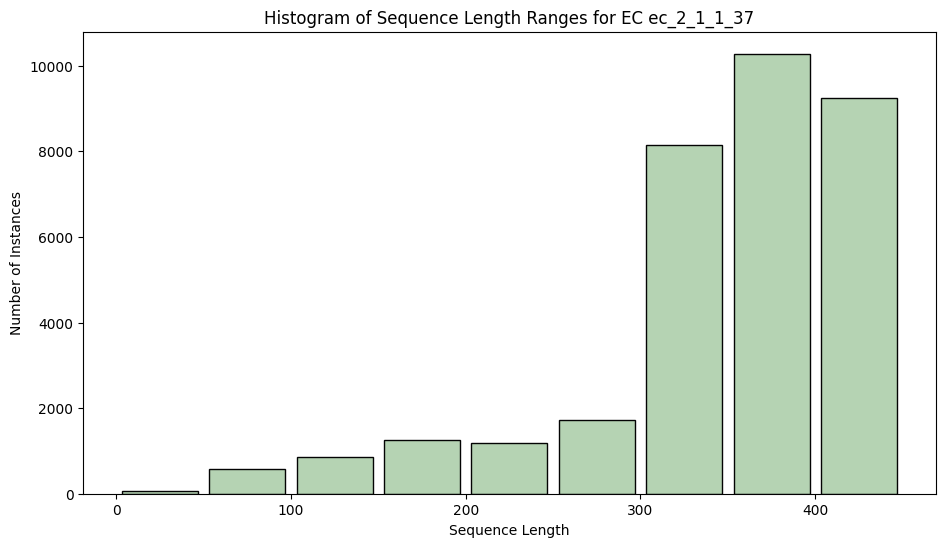

<Figure size 640x480 with 0 Axes>

In [9]:
# We can display the data length distribution in number of amino acids:
path_hist = "data_specific_enzymes/databases/tmp/"
datasetManager.plot_histogram(path_hist)

In [10]:
# then, we split the dataset into training, validation, and test set. 90% training, 5% validatio, 5% test
datasetManager.split_train_test_validation(train_fraction=0.9, validation_fraction=0.05, test_fraction=0.05)

# save datasets as pickle files
pickles_dir = "data_specific_enzymes/databases/pickles_test/"
datasetManager.save_to_pickle(pickles_dir)

# Not needed for this tutorial, but you can save the datasets as fasta files:
# datasetManager.save_to_fasta("data_specific_enzymes/databases/fasta_test/")
# fasta files are usefoul if you want to create filtered test or validation sets
# based on sequence similarity to the training set.

#### Fine-tuning Process
Once the dataset is prepared and formatted correctly, the fine-tuning process can begin. This involves training the model on the new dataset with the encoded keywords, allowing the model to learn and adapt to the specific characteristics and requirements of the task at hand.

During fine-tuning:
- The model adjusts its parameters based on the new data, enhancing its ability to generate or predict sequences that align with the encoded keywords and control codes.
- The training process is guided by the defined keywords, ensuring that the model focuses on the relevant aspects of the protein sequences.

The fine-tuning process is crucial for adapting the pre-trained model to specific tasks, improving its performance, and ensuring that it produces biologically relevant and accurate results.

#### Code
The fine-tuning of Finenzyme is performed using the `pytorch_training.py` module. This can be executed directly from the command line by providing the pre-trained model, the dataset directory (where the training dataset, and optionally the validation dataset are saved), and all the fine-tuning parameters.

**DISCLAIMER**: The fine-tuning step requires a significant amount of time, parallelized hardware (GPU) is recommended.


In [ ]:
import subprocess
# model path: directory where the pre-trained model is saved
model_path = 'ckpt/pretrain_progen_full.pth'

# Define the command as a string
command = f"python pytorch_training.py --model_dir 'ckpt/' --model_path {model_path} --stop_token 1 --model_name {name} --db_directory {pickles_dir}"

# Use subprocess to run the command
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Print the output line by line as it's being generated
for line in iter(process.stdout.readline, b''):
    print(line.decode(), end='')

# Print the error messages, if any
for line in iter(process.stderr.readline, b''):
    print(line.decode(), end='')



MODEL SIZE: 
1280
Found PyTorch checkpoint at  ckpt/pretrain_progen_full.pth
previous checkpoint loaded in GPU
begin training...
Training on family:  ec_2_1_1_37


### Fine-tuning Parameters
The fine-tuning process for the model involves several key parameters, managing the model's learning process. Here is a detailed description of the most important parameters used in the fine-tuning process:

1. **model_dir**: This parameter specifies the directory where the training model checkpoints will be saved. By default, it is set to `'ckpt/'`.

2. **model_path**: This parameter indicates the path to the model checkpoint file to load. It is the specific file within the model directory that contains the pre-trained model's weights. The default value is `'ckpt/pretrain_progen_full.pth'`.

3. **sequence_len**: This parameter defines the sequence length of the model being fine-tuned. It ensures that all sequences are the same length for training. The default length is `511`.

4. **num_epochs**: This parameter specifies the number of epochs for which the model will be trained. An epoch is a full pass through the training dataset. The default value is `8`.

5. **batch_size**: This parameter determines the number of samples processed before the model is updated. The default batch size is `2`.

6. **warmup_iteration**: This parameter indicates the number of iterations for learning rate warm-up. During this period, the learning rate gradually increases to its initial value. The default is `1000`.

7. **save_iter**: This parameter specifies how often (in terms of iterations) the model checkpoint should be saved. The default value is every `10` iterations.

8. **stop_token**: This parameter defines the stop token for fine-tuning, which signals the end of a sequence. The stop token value depends on the fine-tuning vocabulary defined during the dataset creation.

9. **model_name**: This parameter sets the name of the fine-tuning model. The default is `'fine_tuned_model_test'`.

10. **db_directory**: This parameter points to the directory where the fine-tuning dataset is stored. The default path is `'data_specific_enzymes/databases/pickles/'`.
11. **validate**: default=True compute validation loss
12. **early_stop**: default=True early stop if validation loss increase
13. **filtered_validation**: default=False early stop if filtered validation loss increase


<h2>Step 3. Generation through the fine-tuned model</h2>

The generation process using the fine-tuned model (Finenzyme) is designed to produce protein sequences that are more relevant and specific to the tasks or characteristics defined during the fine-tuning phase. The fine-tuned model is utilized after it has been trained on a dataset tailored to the desired outputs, incorporating control codes and keywords to guide the generation.

**Steps Involved:**
1. **Loading the Model**: Finenzyme is loaded from a checkpoint that stores the trained state of the model. This ensures that all the adaptations made during the fine-tuning process are retained.
   
2. **Generating Sequences**: Finenzyme, similarly to the pre-trained one can generate sequences by taking an initial sequence or context and extending it based on the patterns it learned during fine-tuning. The generation process is influenced by the specific keywords and control codes defined in the fine-tuning dataset.

3. **Keywords Specification**: During generation with Finenzyme, it is possible to use the keywords defined duting fine-tuning.


In [ ]:
from generation_manager import GeneratorManager

In [ ]:
# Here we set the model checkpoint path, 
# for this example, we use Finenzyme on phage lysozymes.
model_path = 'ckpt/ec_2_1_1_37_warmup_1000_earlystop_epoch6_015_flip_LR01_2batch.pth' 

# Now, time to set the generator manager with default parameters: penalty = 0, and let's set top-k = 1
# This class loads the model and the tokenizer in memory.
generator = GeneratorManager(model_path, topk = 1)

In [ ]:
# An example sequence: P05102	MTH1_HAEPH	Type II methyltransferase M.HhaI 
# (source: https://www.uniprot.org/uniprotkb/P05102/entry)
sequence = "MIEIKDKQLTGLRFIDLFAGLGGFRLALESCGAECVYSNEWDKYAQEVYEMNFGEKPEGDITQVNEKTIPDHDILCAGFPCQAFSISGKQKGFEDSRGTLFFDIARIVREKKPKVVFMENVKNFASHDNGNTLEVVKNTMNELDYSFHAKVLNALDYGIPQKRERIYMICFRNDLNIQNFQFPKPFELNTFVKDLLLPDSEVEHLVIDRKDLVMTNQEIEQTTPKTVRLGIVGKGGQGERIYSTRGIAITLSAYGGGIFAKTGGYLVNGKTRKLHPRECARVMGYPDSYKVHPSTSQAYKQFGNSVVINVLQYIAYNIGSSLNFKPY"

# keyword IDs in input defined during fine-tuning: (already in control code encoding) 
keywords_finenzyme = [0]

# Next, we set the amino acid prefix to give in input to the model
prefix = 20


In [ ]:
# Last step: generation. With after_n_generation we generate up to the real protein length.
res, tokens_prob, offset = generator.after_n_generation(sequence, keywords_finenzyme, prefix)

In [ ]:
# What happened during generation?
print('Finenzyme generated a protein with a prefix of ', offset, 'amino acids.')
print('Is the predicted protein equal to the real one?', res == sequence[prefix:])
print('Generated protein:')
print(res)
print('Actual protein:')
print(sequence[prefix:])


In [ ]:
# here we search for indices of amino acids that differ from the natural sequence
differing_idx = [(i, [actual, predicted]) for i, (actual, predicted) in enumerate(zip(sequence[prefix:], res)) if actual != predicted]
print(f'The pre-trained model generated an enzyme with {len(differing_idx)} different amino acids from the original one.')

In [ ]:
# we can analyze the probabilities of these indices that we have in output from Finenzyme
from tokenizer import Tokenizer
tokenizer = Tokenizer()
for difference in differing_idx:
    print(f'The predicted sequence in index {difference[0]},'
    f' has probabilities for true aa {difference[1][0]} of {tokens_prob[difference[0]][0][tokenizer.aa_to_probs_index[difference[1][0]]]:.3f},'
    f' and for predicted aa {difference[1][1]} of {tokens_prob[difference[0]][0][tokenizer.aa_to_probs_index[difference[1][1]]]:.3f}')
    break


#### Results Analysis
The generation process (following the pre-trained generation process in this notebook) began with the input sequence of the Type II methyltransferase P05102 and the keyword defined during fine-tuning related to the EC family of this entry, namely EC 2.1.1.37.

The model generated a sequence with a specified prefix length, and the resulting sequence was compared to the original protein sequence.

- **Generated Sequence**: The pre-trained model produced a protein sequence with an initial prefix of 20 amino acids provided as input. The rest of the sequence was generated based on the model's learned patterns and the specified keywords.
- **Comparison to Actual Sequence**: The generated sequence was compared to the actual sequence starting from the 20th amino acid. It was noted that there were differences in several amino acids between the generated and actual sequences.
- **Differing Indices**: The specific indices where the generated sequence differed from the actual sequence were identified. The analysis found a certain number of amino acids that did not match, indicating areas where the model's predictions deviated from the natural sequence.
- **Probability Analysis**: For the differing amino acids, the probabilities assigned by the model to both the actual and predicted amino acids were examined. This provides insight into the model's confidence in its predictions and highlights the areas where it may have uncertain.

#### Conclusion
Finenzyme generated a protein sequence influenced by the input fine-tuned keyword. Using the same sampling methods (top-k with k = 1) as before with the pre-trained model, the generated sequence was still not identical to the natural one, but closer: 71 different amino acids instead of 259.